<a href="https://colab.research.google.com/github/Bakarime27/app-sante-public/blob/main/exploration_data_asp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Concevoir une application au service de la santé publique**
Ce projet consiste à traiter les données **Open Food Facts** tout en ayant à l'idée de proposer une application qui répond à un appel à projet de la santé publique.

### **1.&nbsp;Description du dataset**
Le dataset contient la liste de plus de 300000 produits avec leurs ingrédients et les valeurs calorifiques et nutritionnelles.



*   Les colonnes qui se terminent en _t sont les dates sous le format unix timestamp
*   Les colonnes qui se terminent en _datetime sont les dates sous le format iso8601
*   Les colonnes qui se terminent en _100g correspondent à la quantité de nutriments contenue dans 100g ou 100ml de produit
*   Les colonnes qui se terminent avec _serving correspondent à la quantité de nutriments contenue dans une portion de produit 
*   nutrition-score-fr_100g correspond au score nutritionnel d'un produit variant de -15 à 40, plus bas est le score plus le produit est sain
*   nutrition_grade_fr_100g correspond à une simple catégorisation du nutriscore, les valeurs allant de A jusqu'à E

### **2.&nbsp;Exploration des données**

In [1]:
from google.colab import drive
#drive.mount("/gdrive", force_remount=True)
#drive.flush_and_unmount()
drive.mount('/gdrive')
%cd /gdrive/MyDrive/Datasets
%ls

Mounted at /gdrive
/gdrive/MyDrive/Datasets
clean-data.csv  fr.openfoodfacts.org.products.csv  taux-remplissage.png


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('clean-data.csv', sep='\t', low_memory=False)

In [4]:
print(f'Le dataset contient {df.shape[0]} lignes et {df.shape[1]} colonnes')

Le dataset contient 30200 lignes et 29 colonnes


### **2.1.&nbsp;Analyse univariée**


### **2.1.1.&nbsp;Répartition des nutrigrades et nutriscores**

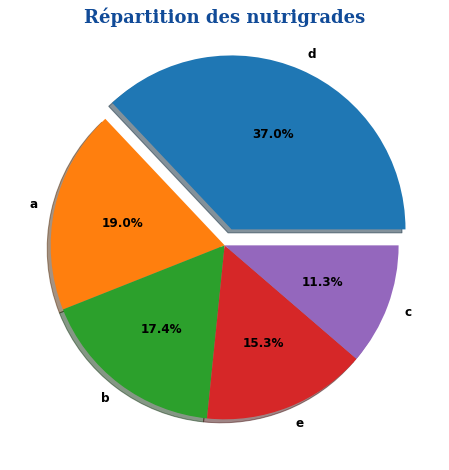

In [7]:
#Répartition des nutrigrades par le camembert
nutrigrade = df.groupby(by='nutrition_grade_fr')['code'].nunique().sort_values(ascending=False)

font_title = {'family': 'serif',
              'color':  '#114b98',
              'weight': 'bold',
              'size': 18,
             }
           
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(aspect="equal"))

explodes = np.zeros(5)
explodes[0] = .1

plt.pie(nutrigrade, labels=nutrigrade.index, 
        startangle=0, 
        shadow=True,
        explode=explodes,
        autopct='%1.1f%%',
        textprops=dict(color="black",size=12, weight="bold"))
plt.title("Répartition des nutrigrades", fontdict=font_title)
plt.show()

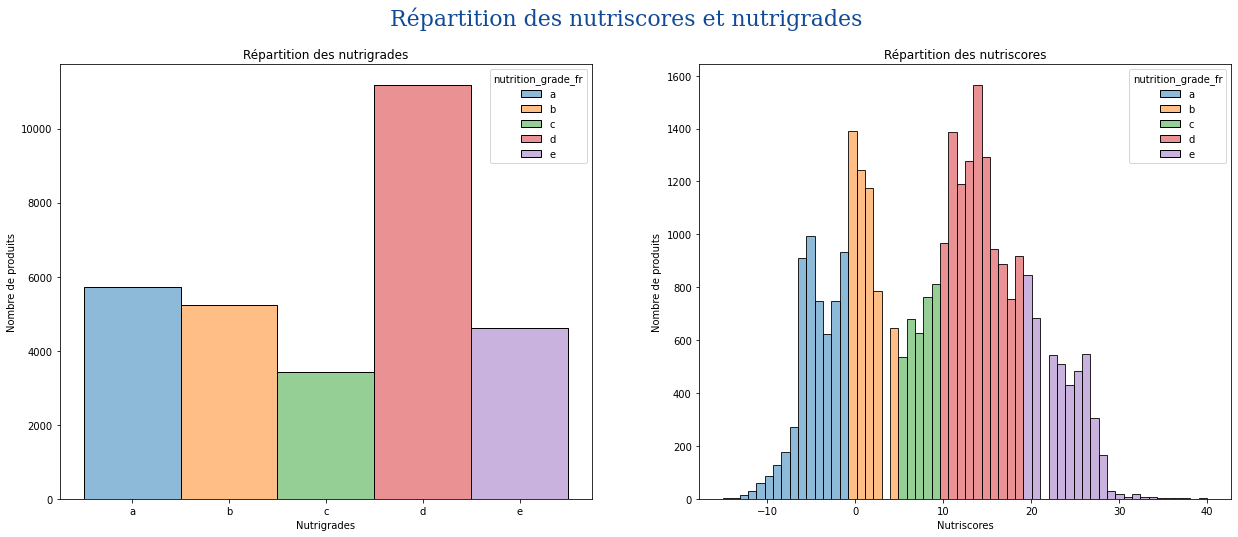

In [6]:
#Répartition des nutriscores et nutrigrades
fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(21,8))
fig.suptitle(r"Répartition des nutriscores et nutrigrades" "\n", fontdict=font_title, fontsize=22)

sns.histplot(data=df.sort_values("nutrition_grade_fr"), x="nutrition_grade_fr", hue="nutrition_grade_fr", ax=axes[0])
axes[0].set_title('Répartition des nutrigrades')
axes[0].set_xlabel("Nutrigrades")
axes[0].set_ylabel("Nombre de produits")

sns.histplot(data=df.sort_values("nutrition_grade_fr"), x="nutrition-score-fr_100g", hue="nutrition_grade_fr", ax=axes[1])
axes[1].set_title('Répartition des nutriscores')
axes[1].set_xlabel("Nutriscores")
axes[1].set_ylabel("Nombre de produits")

plt.show()

Le nutigrade est plutôt réparti de manière équitable a l'exception de la classe D

### **2.2.&nbsp;Analyse bivariée**

### **2.2.1.&nbsp;Répartition du taux de sucre par nutrigrade**



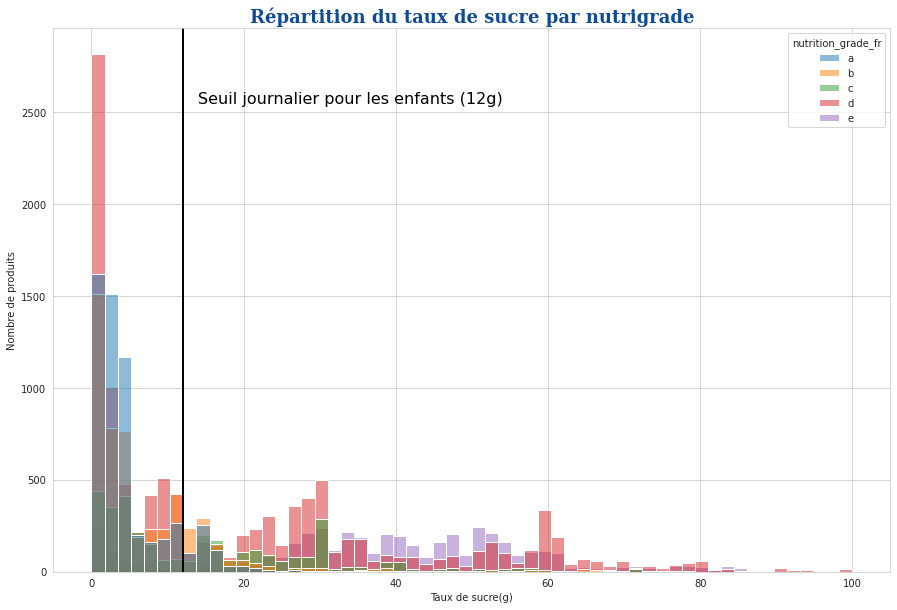

In [7]:
#Nous allons analyser la distribution du taux de sucre
#taux_de_sucre = df[['sugars_100g']]

fig=plt.figure(figsize=(15,10))

font_title = {'family': 'serif',
              'color':  '#114b98',
              'weight': 'bold',
              'size': 18,
             }
seuil_sucre = 12
sns.set_style("whitegrid")
sns.histplot(data=df.sort_values("nutrition_grade_fr"), x='sugars_100g', hue="nutrition_grade_fr", color='#00afe6')
plt.axvline(x=seuil_sucre, linewidth=2, color = 'black')
plt.text(seuil_sucre+2, 2550, 'Seuil journalier pour les enfants (12g)', fontsize = 16, color = 'black')

plt.title("Répartition du taux de sucre par nutrigrade", fontdict=font_title)
plt.xlabel("Taux de sucre(g)")
plt.ylabel("Nombre de produits")
plt.show()


Nous observons des produits dont le taux de sucre est au delà du seuil, 12g pour 100g de produit, avec un nutrigrade compris entre a et c. 

### **2.2.2.&nbsp;Analyse de variance (ANOVA)**


Afin de vérifier si la catégorie pnns_groups_1 influence rééllement le taux de sucre, nous pouvons réaliser une ANOVA (Analyse de la variance). 

Les hypothèses posées seront donc les suivantes :

*  H0 : La distribution des échantillons est similaire (et donc la catégorie n'a aucune influence sur le taux de sucre).
*  H1 : Une ou plusieurs distributions sont inégales.  

Pour commencer, nous pouvons projeter les boxplots de la répartition du taux de sucre par catégorie pnns_groups_1 pour également vérifier les hypothèses de départ liées à l'ANOVA à savoir :

*  Les observations sont indépendantes et identiquement distribuées (iid)
*  Les observations ont la même variance
*  Les observations sont normalement distribuées

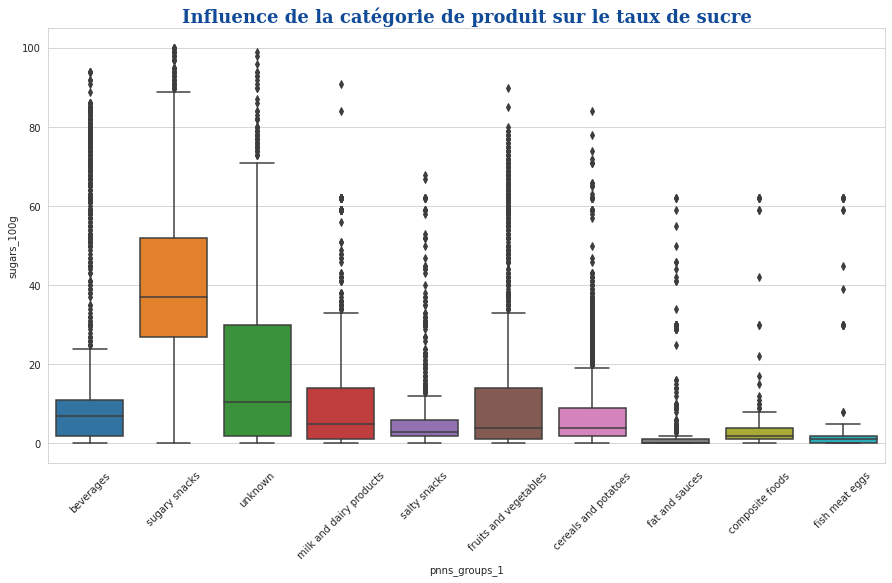

In [8]:
fig = plt.figure(figsize=(15,8))
ax = sns.boxplot(data=df, x='pnns_groups_1', y='sugars_100g')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.title("Influence de la catégorie de produit sur le taux de sucre", fontdict=font_title)
plt.show()

Nous voyons que les catégories sont plutôt différentes, dans la mesure où les variances et les moyennes sont à des échelles différentes

Nous allons maintenant appliquer l'ANOVA pour confirmer ou infirmer notre analyse de variance

In [9]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

anova_category = smf.ols('sugars_100g~pnns_groups_1', data=df).fit()
print(anova_category.summary())

                            OLS Regression Results                            
Dep. Variable:            sugars_100g   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     2244.
Date:                Wed, 31 Aug 2022   Prob (F-statistic):               0.00
Time:                        00:03:44   Log-Likelihood:            -1.2592e+05
No. Observations:               30200   AIC:                         2.519e+05
Df Residuals:                   30190   BIC:                         2.519e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [10]:
#Tableau d'analyse de variance
sm.stats.anova_lm(anova_category, typ=2)

,sum_sq,df,F,PR(>F)
pnns_groups_1,4.949578e+06,9.0,2244.140199,0.0
Residual,7.398416e+06,30190.0,NaN,NaN


Les résultats du test de Fisher nous indiquent ici une p-value très proche de 0 pour l'ensemble des catégories, donc inferieur au niveau de test de 5%.  
Nous rejetons donc l'hypothèse H0 selon laquelle les distributions sont identiques.  
La catégorie de produit a donc bien une influence sur le taux de sucre.

### **2.3.&nbsp;Analyse multivariée**


### **2.3.1.&nbsp;Corrélations linéaires**


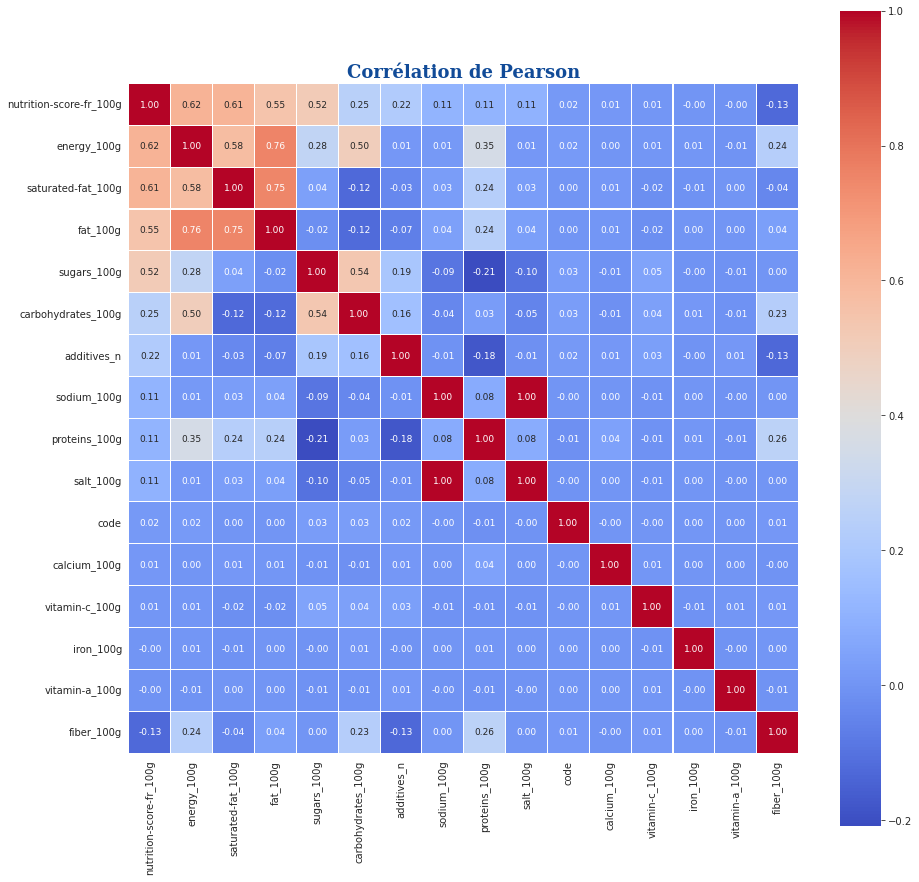

In [11]:
#Matrice des corrélations
corr_mat = df.corr()
cols = corr_mat.nlargest(16,'nutrition-score-fr_100g')['nutrition-score-fr_100g'].index
corr_nutriscore = corr_mat.loc[cols, cols]
#heatmap
fig = plt.figure(figsize=(15,15))
sns.heatmap(corr_nutriscore, cbar=True, fmt='.2f', annot_kws={'size': 9}, square=True, linewidths=0.01, annot=True, cmap='coolwarm')
plt.title("Corrélation de Pearson", fontdict=font_title)
plt.show()

Cette matrice nous confirme certaines corrélations évidentes entre salt_100g et sodium_100g, entre sugars_100g et carbohydrates_100g, entre fat_100g et saturated-fat_100g. On contate également que le nutriscore est plus corrélé à certaines variables plus que d'autres.

### **2.3.2.&nbsp;Analyse en composantes principales (PCA)**

**Eboulis des valeurs propres**

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df_pca = df[df.columns.difference(["code","nutrition-score-fr_100g"])]

scaler = StandardScaler()

#standardisation
X = df_pca.select_dtypes(include=['float64','int64'])
X_standard = scaler.fit_transform(X)

#Instanciation de l'ACP
pca = PCA(svd_solver='full').fit(X_standard)
X_projete = pca.transform(X_standard)


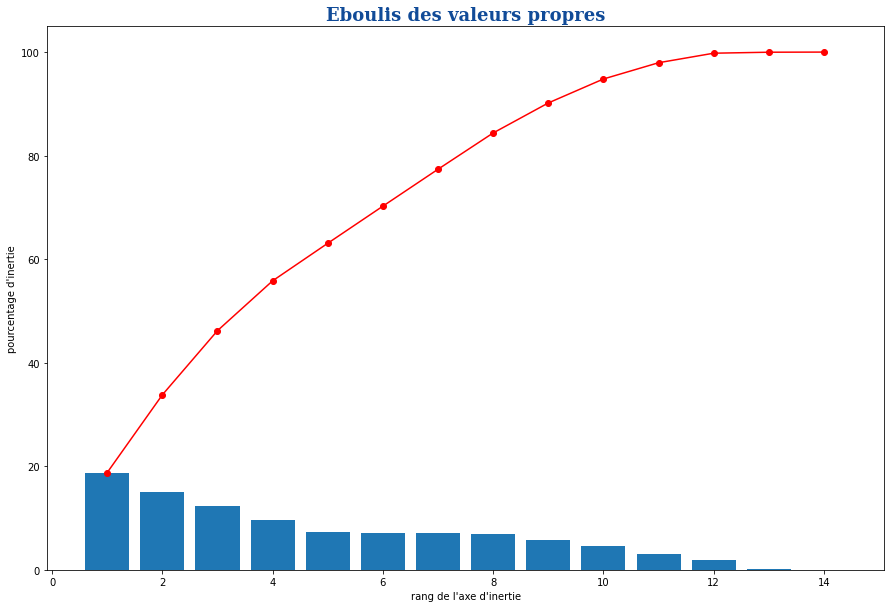

In [10]:
#Variances expliquées
variances_expliquees = pca.explained_variance_ratio_*100

#Projection de l'éboulis des valeurs propres
plt.figure(figsize=(15,10))
plt.bar(np.arange(len(variances_expliquees))+1, variances_expliquees)
plt.plot(np.arange(len(variances_expliquees))+1, variances_expliquees.cumsum(),c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres", fontdict=font_title)
plt.show(block=False)

Les 4 premiers plan factoriels couvrent plus de 80% de l'inertie totale, il serait donc judicieux de condidérer les 8 premiers axes d'inertie F1,...,F8.

**Cercle des corrélations**

Nous commençons par le tableau de correlations entre les variables initiales et les axes d'inertie.

In [11]:
#Espace des composantes principales
pcs = pca.components_

#Matrice des corrélations variables x facteurs
p = X.shape[1]
sqrt_valprop = np.sqrt(pca.explained_variance_)
corvar = np.zeros((p, p))
for dim in range(p):
    corvar[:,dim] = pcs[dim,:] * sqrt_valprop[dim]

#on affiche pour les deux premiers plans factoriels 
corr_matrix = pd.DataFrame({'feature':X.columns,'CORR_F1':corvar[:,0],'CORR_F2':corvar[:,1], 
              'CORR_F3':corvar[:,2], 'CORR_F4':corvar[:,3],'CORR_F5':corvar[:,4],'CORR_F6':corvar[:,5],'CORR_F7':corvar[:,6],'CORR_F8':corvar[:,7]})
corr_matrix

,feature,CORR_F1,CORR_F2,CORR_F3,CORR_F4,CORR_F5,CORR_F6,CORR_F7,CORR_F8
0,additives_n,-0.076535,-0.204637,0.355393,-0.480731,0.086176,0.095005,-0.001091,-0.035498
1,calcium_100g,0.020002,0.017445,-0.027011,0.023143,0.595037,0.676905,-0.207938,-0.351677
2,carbohydrates_100g,0.246492,-0.476474,0.712951,0.217469,-0.032467,0.005402,0.005901,-0.056663
3,energy_100g,0.924862,-0.215286,0.168417,0.012065,-0.017262,-0.004793,0.007031,-0.013238
4,fat_100g,0.856151,0.060206,-0.292538,-0.264030,-0.011144,-0.014874,0.004476,0.027504
5,fiber_100g,0.257338,-0.077392,0.160594,0.740552,0.011398,-0.046812,0.021749,-0.010938
6,iron_100g,0.006162,0.000338,0.011419,0.033659,-0.328762,0.661297,0.542199,0.398848
7,proteins_100g,0.487055,0.182011,-0.177113,0.522474,0.089188,0.042666,-0.008106,0.000790
8,salt_100g,0.127002,0.860493,0.486143,-0.059569,-0.006906,-0.005330,-0.000577,-0.004448
9,saturated-fat_100g,0.780191,0.058295,-0.296261,-0.345140,0.000318,-0.006051,-0.006588,0.022842


Le tableau de correlations nous permet d'identifier les variables initiales et les axes d'inertie qui sont fortement corrélées. Nous allons poursuivre l'analyse avec le cercle de correlations

In [12]:
#Variable Illustrative
nutrigrade_vi = df['nutrition_grade_fr'].values

#Encodage des grades
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
nutrigrade_vi = encoder.fit_transform(nutrigrade_vi)
nutrigrade_vi = nutrigrade_vi.reshape((nutrigrade_vi.shape[0],1))

#Corrélation de la variable illustrative avec les axes factoriels 
corrIv = np.zeros((nutrigrade_vi.shape[1],p))
for j in range(p): 
    for k in range(nutrigrade_vi.shape[1]): 
        corrIv[k,j] = np.corrcoef(nutrigrade_vi[:,k],X_projete[:,j])[0,1]

In [13]:
def cercle_corr(pcs, n_comp, pca, axis_ranks, 
               labels=None, label_rotation=0, 
               illustrative_var_label=None, illustrative_var_corr=None):
    for d1, d2 in axis_ranks:
        if d2 < n_comp:
            
            # initialisation de la figure
            fig=plt.figure(figsize=(10,10))
            fig.subplots_adjust(left=0.1,right=0.9,bottom=0.1,top=0.9)
            ax=fig.add_subplot(111)
            ax.set_aspect('equal', adjustable='box') 

            #détermination des limites du graphique
            ax.set_xlim(-1,1) 
            ax.set_ylim(-1,1) 

            #affichage des flèches 
            plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                       pcs[d1,:],pcs[d2,:], 
                       angles='xy', scale_units='xy', scale=1, 
                       color="grey", alpha=0.5)
            
            # et noms de variables
            for i,(x,y) in enumerate(pcs[[d1,d2]].T):
                plt.annotate(labels[i],(x,y),
                             ha='center', va='center',
                             fontsize='14',color="#17aafa", alpha=0.8) 

            #variable illustrative
            if illustrative_var_label is not None :
                plt.annotate(illustrative_var_label,
                             (illustrative_var_corr[0,d1],illustrative_var_corr[0,d2]),
                             color='g')
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                                   illustrative_var_corr[0,d1],illustrative_var_corr[0,d2], 
                                   angles='xy', scale_units='xy', scale=1, color="g", alpha=0.5)

            #ajouter les axes 
            plt.plot([-1,1],[0,0],linewidth=1, color='grey', ls='--') 
            plt.plot([0,0],[-1,1],linewidth=1, color='grey', ls='--')

            #ajouter un cercle 
            cercle = plt.Circle((0,0),1,color='#17aafa',fill=False) 
            ax.add_artist(cercle) 

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1), fontdict=font_title)
            plt.show(block=False)

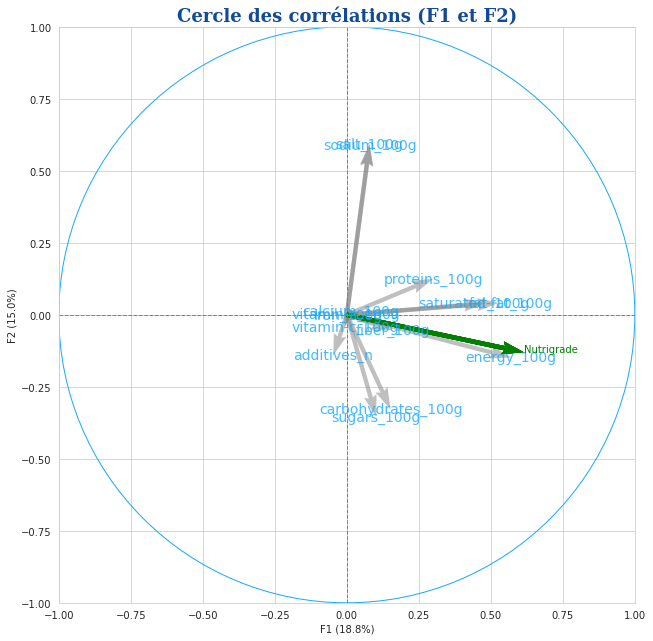

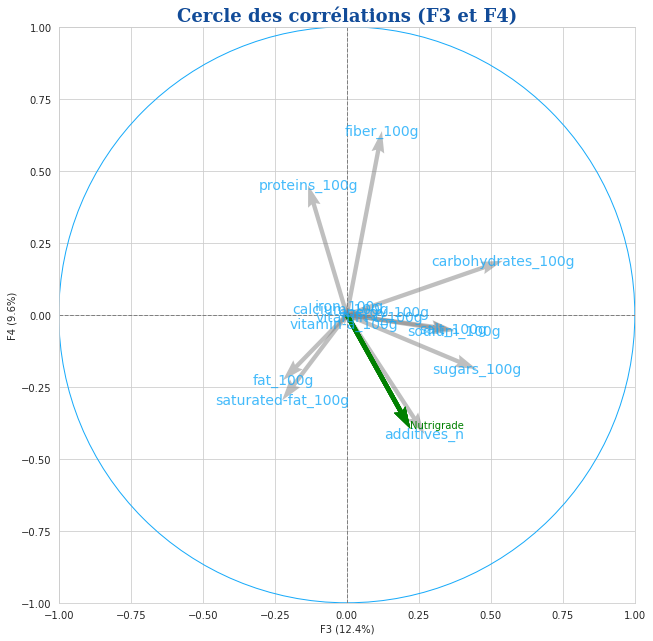

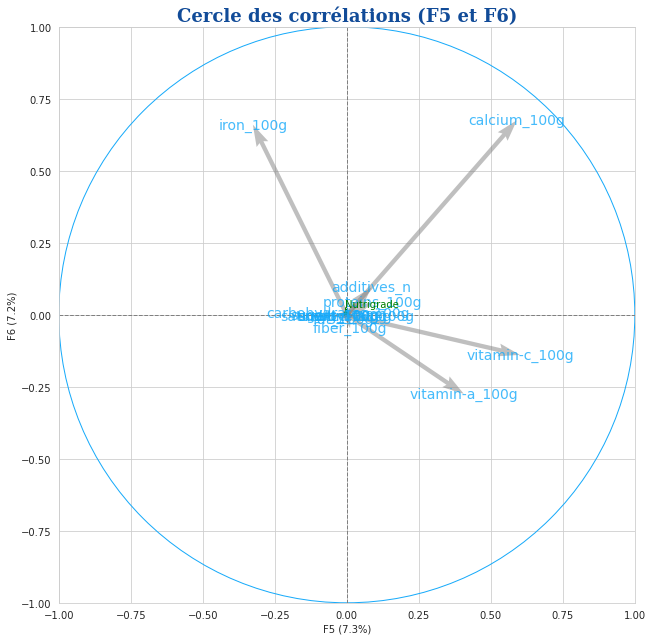

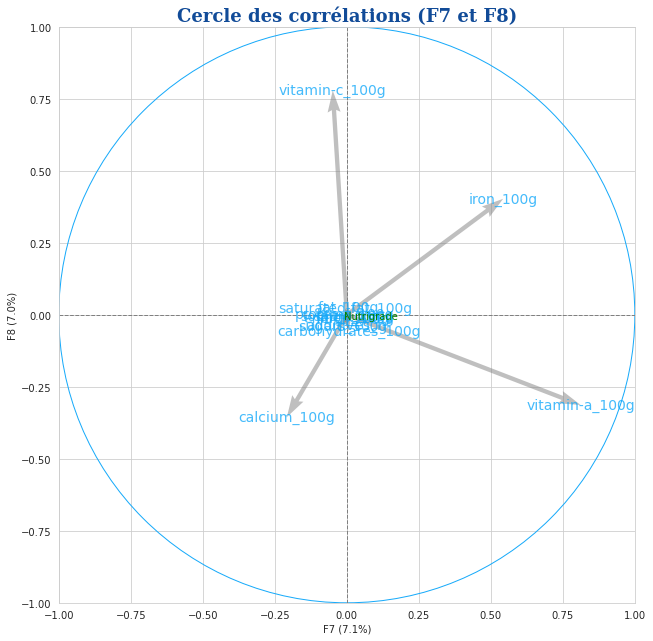

In [17]:
cercle_corr(pcs, 8, pca, [(0,1),(2,3),(4,5),(6,7)], labels = np.array(X.columns), 
           illustrative_var_label="Nutrigrade", illustrative_var_corr = corrIv)

Dans cette analyse on s'intéresse aux variables (nutriments) qui rentrent en ligne en compte dans le calcul du nutriscore. L'analyse des différents de cercles de corrélations nous montrent que les axes F1,...,F4 sont les axes d'intérêt car ils présentent de fortes corrélations avec les variables (nutriments) liés au nutriscore.

**Projection des produits sur les plans factoriels**

In [14]:
def graphe_plans_factoriels(X_projete, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(12,8))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projete[:, d1], X_projete[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projete[selected, d1], X_projete[selected, d2], alpha=alpha, label=value)
                plt.legend()
            if labels is not None:
                for i,(x,y) in enumerate(X_projete[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
            
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projete[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des {} individus sur F{} et F{}".format(X_projete.shape[0], d1+1, d2+1), fontdict=font_title)
            plt.show(block=False)

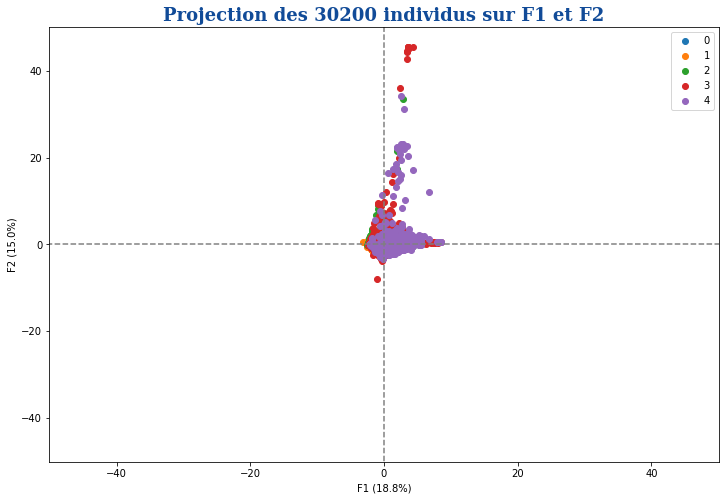

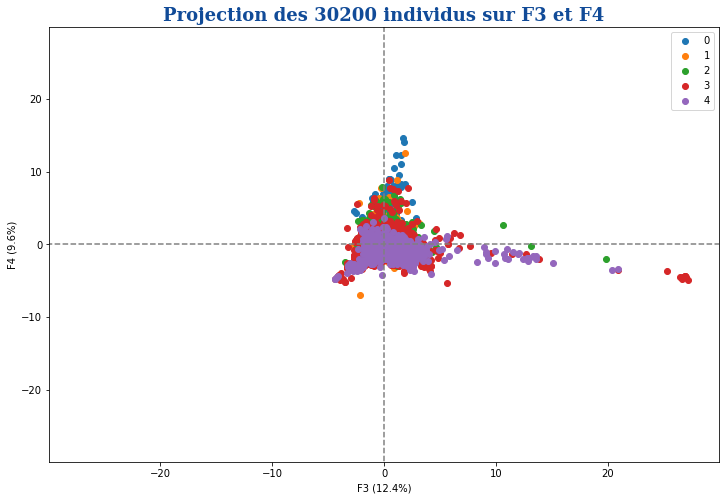

In [15]:
graphe_plans_factoriels(X_projete, 4, pca, [(0,1),(2,3)], illustrative_var = nutrigrade_vi)

Cette projection des points sur les quatre premiers axes d'inertie nous montre la répartitions des points selon le nutrigrade. On constate une concentration des points avec un nutrigrade de soit d ou e au centre du plan.

**Calcul de COS² et CTR**

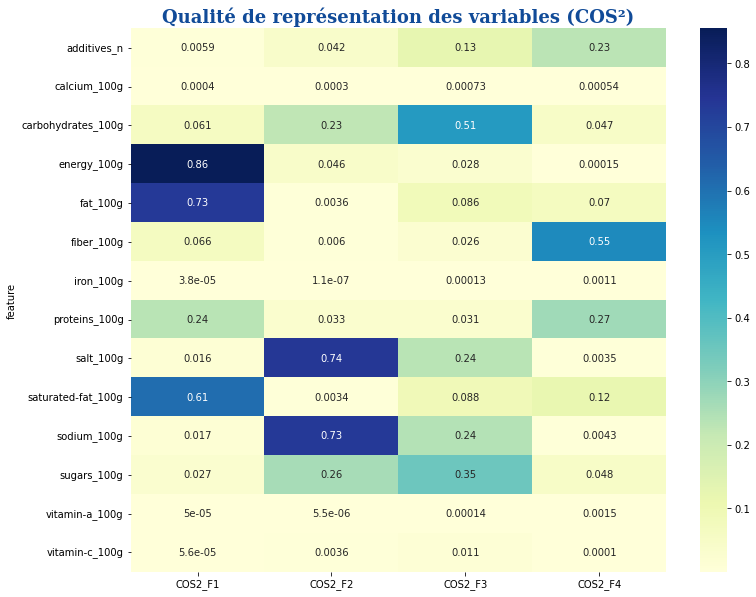

In [16]:
#Calcul des COS²
cos2var = corvar**2
df_cos2var = pd.DataFrame({'feature':X.columns,'COS2_F1':cos2var[:,0],
                           'COS2_F2':cos2var[:,1], 'COS2_F3':cos2var[:,2],
                           'COS2_F4':cos2var[:,3]}).set_index('feature')

#affichage dans un heatmap seaborn
fig = plt.figure(figsize=(12,10))
sns.heatmap(df_cos2var, annot=True, cmap="YlGnBu")
plt.title("Qualité de représentation des variables (COS²)", fontdict=font_title)
plt.show()

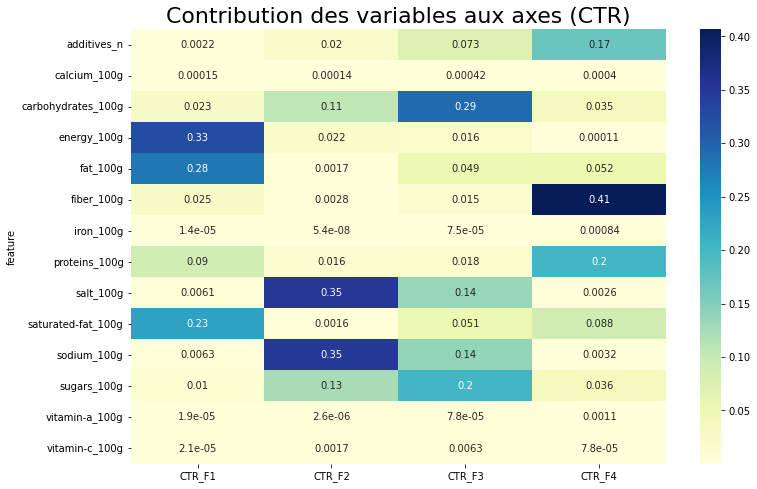

In [17]:
#contributions 
ctrvar = cos2var 
for k in range(p): 
    ctrvar[:,k] = ctrvar[:,k]/pca.explained_variance_[k] 

df_ctrvar = pd.DataFrame({'feature':X.columns,'CTR_F1':ctrvar[:,0],'CTR_F2':ctrvar[:,1],
                         'CTR_F3':ctrvar[:,2], 'CTR_F4':ctrvar[:,3]}).set_index('feature')

#affichage dans un heatmap seaborn
fig = plt.figure(figsize=(12,8))
sns.heatmap(df_ctrvar, annot=True, cmap="YlGnBu")
plt.title("Contribution des variables aux axes (CTR)", fontsize=22)
plt.show()

On peut conclure que :
* l'axe F1 représente le niveau d'énergie
* l'axe F2 représente la teneur en sel
* l'axe F3 représente la teneur en sucre
* l'axe F4 représente la teneur en fibre et protéine

**Proposition d'un nouveau score basé sur le taux de sucre**

Nous allons ajouter les variables synthétiques F1,...,F4 à notre dataset

In [18]:
df_var_syn = pd.DataFrame(X_projete[:,:4], index=df.index, 
                          columns=["F"+str(i+1) for i in range(4)])
df_extend = pd.concat([df, df_var_syn], axis=1)
df_extend.head()

,code,last_modified_datetime,creator,created_datetime,url,states_fr,countries_fr,product_name,brands,energy_100g,...,iron_100g,vitamin-a_100g,pnns_groups_2,pnns_groups_1,categories_fr,main_category_fr,F1,F2,F3,F4
0,40608754,2015-08-09T17:35:31Z,andre,2012-08-15T09:48:28Z,http://world-fr.openfoodfacts.org/produit/0000...,"A vérifier,Complet,Informations nutritionnelle...",France,"Pepsi, Nouveau goût !",Pepsi,177.0,...,0.006,0.000195,sweetened beverages,beverages,"Boissons,Boissons gazeuses,Sodas,Sodas au cola...",Sodas,-2.146539,0.153357,-0.582407,-0.626424
1,87177756,2015-06-06T11:13:26Z,tacite,2015-06-06T10:28:06Z,http://world-fr.openfoodfacts.org/produit/0000...,"A vérifier,Complet,Informations nutritionnelle...",France,7Up,"7Up,Pepsico",177.0,...,0.006,0.000195,sweetened beverages,beverages,"Aliments et boissons à base de végétaux,Boisso...",Sodas aux fruits,-2.163196,0.113595,-0.463765,-0.793880
2,10,2016-10-20T09:14:39Z,jeanbono,2016-10-20T07:19:01Z,http://world-fr.openfoodfacts.org/produit/0000...,"A vérifier,Complet,Informations nutritionnelle...",France,Madeleines nature,Bijou,1900.0,...,0.006,0.000195,biscuits and cakes,sugary snacks,"Snacks sucrés,Biscuits et gâteaux,Desserts,Gât...",Gâteaux,0.543078,-0.615824,1.058956,-0.584843
3,30,2016-12-15T22:24:04Z,beniben,2016-12-15T22:15:44Z,http://world-fr.openfoodfacts.org/produit/0000...,"A vérifier,Complet,Informations nutritionnelle...",France,Cakes Raisins,Bijou,1768.0,...,0.006,0.000195,biscuits and cakes,sugary snacks,"Snacks sucrés,Biscuits et gâteaux,Desserts,Gât...",Gâteaux,0.345345,-0.649756,1.150436,-0.546974
4,31,2016-08-18T20:16:30Z,beniben,2016-07-08T21:55:54Z,http://world-fr.openfoodfacts.org/produit/0000...,"A vérifier,Complet,Informations nutritionnelle...",France,Cakes aux Fruits,Bijou,1670.0,...,0.006,0.000195,biscuits and cakes,sugary snacks,"Snacks sucrés,Biscuits et gâteaux,Desserts,Gât...",Pâtisseries,0.047018,-1.162424,2.057038,-1.589826


In [19]:
df_extend.describe()

,code,energy_100g,proteins_100g,salt_100g,sodium_100g,additives_n,sugars_100g,fat_100g,carbohydrates_100g,saturated-fat_100g,nutrition-score-fr_100g,fiber_100g,calcium_100g,vitamin-c_100g,iron_100g,vitamin-a_100g,F1,F2,F3,F4
count,3.020000e+04,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,3.020000e+04,3.020000e+04,3.020000e+04,3.020000e+04
mean,3.841373e+12,1240.503344,6.607947,0.655894,0.269579,1.857406,17.432881,14.555608,34.548599,6.276325,9.105762,2.627219,0.142330,0.014301,0.007431,0.000200,-6.399590e-17,-7.528930e-18,3.011572e-17,1.882232e-17
std,5.732454e+12,805.078485,6.480629,2.648085,1.034010,2.496645,20.220967,17.697790,28.280690,9.184369,9.485699,3.671452,0.458477,0.008398,0.149820,0.000690,1.621049e+00,1.449897e+00,1.317693e+00,1.160996e+00
min,1.000000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.166057e+00,-7.979358e+00,-4.366981e+00,-6.934939e+00
25%,3.228881e+12,423.000000,2.000000,0.000000,0.011811,0.000000,2.000000,1.000000,5.930000,0.000000,1.000000,0.000000,0.130000,0.014000,0.006000,0.000195,-1.488025e+00,-6.785505e-01,-8.010259e-01,-6.353694e-01
50%,3.301597e+12,1362.000000,6.000000,0.000000,0.082677,1.000000,8.000000,7.400000,31.500000,2.000000,10.000000,2.000000,0.130000,0.014000,0.006000,0.000195,-8.994711e-02,4.628387e-02,-4.825281e-02,-1.174924e-01
75%,3.596710e+12,1842.000000,9.000000,1.000000,0.354331,3.000000,29.000000,24.000000,60.300000,10.000000,16.000000,4.000000,0.130000,0.014000,0.006000,0.000195,1.125823e+00,5.093203e-01,7.137311e-01,5.341435e-01
max,3.564707e+14,3700.000000,93.000000,100.000000,39.370079,31.000000,100.000000,100.000000,100.000000,100.000000,40.000000,86.000000,69.500000,1.200000,25.000000,0.120000,8.505405e+00,4.553631e+01,2.720359e+01,1.457780e+01


Basée sur les cercles de corrélations, la méthode de calcul du nouveau score que nous adoptons est la suivante

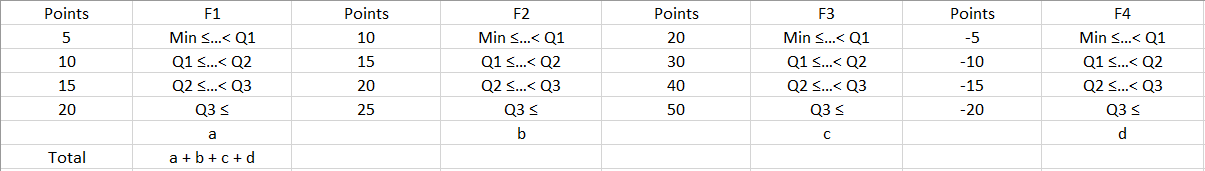

Dans le tableau :

*   Min correspond à la valeur minimale
*   Q1, Q2 et Q3 correspondent aux 3 quartiles

Le principe du nouveau score se base sur l'ancien, c'est à dire les produits avec un score élévé seront mal classés. Les points attribués à F1 (axe portant le niveau d'énergie) sont mois élévés comparés à ceux de F2 (axe portant la teneur en sel). Les points attribués à F3 (axe portant la teneur en sucre) représenetent le double de ceux attribués à F2, car nous souhaitons dans ce score plus pénaliser les produits à forte teneur en sucre. L'axe F4 (axe portant la teneur en fibre et protéine) permet de retrancher des points.



In [20]:
def calcul_stats(df, cols = ['F1','F2','F3','F4']):
  stats = {}
  for col in cols:
    stats[col] = {}
    stats[col]['Min'] = df[col].min()
    stats[col]['Max'] = df[col].max()
    stats[col]['Q1'] = df[col].quantile(0.25)
    stats[col]['Q2'] = df[col].quantile(0.50)
    stats[col]['Q3'] = df[col].quantile(0.75)
  return stats


In [21]:
stats = calcul_stats(df_extend)

In [22]:
def calcul_nouveau_score(row, stats):
  if ((row["F1"] >= stats["F1"]["Min"]) & (row["F1"] < stats["F1"]["Q1"])):
    a = 5
  elif ((row["F1"] >= stats["F1"]["Q1"]) & (row["F1"] < stats["F1"]["Q2"])):
    a = 10
  elif ((row["F1"] >= stats["F1"]["Q2"]) & (row["F1"] < stats["F1"]["Q3"])):
    a = 15
  else:
    a = 20
  if ((row["F2"] >= stats["F2"]["Min"]) & (row["F2"] < stats["F2"]["Q1"])):
    b = 10
  elif ((row["F2"] >= stats["F2"]["Q1"]) & (row["F2"] < stats["F2"]["Q2"])):
    b = 15
  elif ((row["F2"] >= stats["F2"]["Q2"]) & (row["F2"] < stats["F2"]["Q3"])):
    b = 20
  else:
    b = 25
  if ((row["F3"] >= stats["F3"]["Min"]) & (row["F3"] < stats["F3"]["Q1"])):
    c = 20
  elif ((row["F3"] >= stats["F3"]["Q1"]) & (row["F3"] < stats["F3"]["Q2"])):
    c = 30
  elif ((row["F3"] >= stats["F3"]["Q2"]) & (row["F3"] < stats["F3"]["Q3"])):
    c = 40
  else:
    c = 50
  if ((row["F4"] >= stats["F4"]["Min"]) & (row["F4"] < stats["F4"]["Q1"])):
    d = -5
  elif ((row["F4"] >= stats["F4"]["Q1"]) & (row["F4"] < stats["F4"]["Q2"])):
    d = -10
  elif ((row["F4"] >= stats["F4"]["Q2"]) & (row["F4"] < stats["F4"]["Q3"])):
    d = -15
  else:
    d = -20
  
  nouveau_score = a + b + c + d
  return nouveau_score

Le nouveau grade se compose de 4 lettres 


*   w : produit accepté pour les enfants
*   x : produit toléré mais de préférence à éviter pour les enfants
*   y : produit pas recommandé pour les enfants
*   z : produit interdit pour les enfants



In [23]:
def calcul_nouveau_grade(row):
  if  ((row["nouveau_score"] >= 25) & (row["nouveau_score"] < 30)):
    nouveau_grade = "w"
  elif ((row["nouveau_score"] >= 30) & (row["nouveau_score"] < 40)) :
    nouveau_grade = "x"
  elif ((row["nouveau_score"] >= 40) & (row["nouveau_score"] < 60)) :
    nouveau_grade = "y"
  else:
    nouveau_grade = "z"
  return nouveau_grade

In [24]:
df_extend['nouveau_score'] = df_extend.apply(lambda row: calcul_nouveau_score(row, stats),axis=1)
df_extend['nouveau_grade'] = df_extend.apply(lambda row: calcul_nouveau_grade(row),axis=1)

In [25]:
df_extend.describe()

,code,energy_100g,proteins_100g,salt_100g,sodium_100g,additives_n,sugars_100g,fat_100g,carbohydrates_100g,saturated-fat_100g,...,fiber_100g,calcium_100g,vitamin-c_100g,iron_100g,vitamin-a_100g,F1,F2,F3,F4,nouveau_score
count,3.020000e+04,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,...,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,3.020000e+04,3.020000e+04,3.020000e+04,3.020000e+04,30200.000000
mean,3.841373e+12,1240.503344,6.607947,0.655894,0.269579,1.857406,17.432881,14.555608,34.548599,6.276325,...,2.627219,0.142330,0.014301,0.007431,0.000200,-6.399590e-17,-7.528930e-18,3.011572e-17,1.882232e-17,52.500000
std,5.732454e+12,805.078485,6.480629,2.648085,1.034010,2.496645,20.220967,17.697790,28.280690,9.184369,...,3.671452,0.458477,0.008398,0.149820,0.000690,1.621049e+00,1.449897e+00,1.317693e+00,1.160996e+00,11.217338
min,1.000000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-3.166057e+00,-7.979358e+00,-4.366981e+00,-6.934939e+00,25.000000
25%,3.228881e+12,423.000000,2.000000,0.000000,0.011811,0.000000,2.000000,1.000000,5.930000,0.000000,...,0.000000,0.130000,0.014000,0.006000,0.000195,-1.488025e+00,-6.785505e-01,-8.010259e-01,-6.353694e-01,45.000000
50%,3.301597e+12,1362.000000,6.000000,0.000000,0.082677,1.000000,8.000000,7.400000,31.500000,2.000000,...,2.000000,0.130000,0.014000,0.006000,0.000195,-8.994711e-02,4.628387e-02,-4.825281e-02,-1.174924e-01,50.000000
75%,3.596710e+12,1842.000000,9.000000,1.000000,0.354331,3.000000,29.000000,24.000000,60.300000,10.000000,...,4.000000,0.130000,0.014000,0.006000,0.000195,1.125823e+00,5.093203e-01,7.137311e-01,5.341435e-01,60.000000
max,3.564707e+14,3700.000000,93.000000,100.000000,39.370079,31.000000,100.000000,100.000000,100.000000,100.000000,...,86.000000,69.500000,1.200000,25.000000,0.120000,8.505405e+00,4.553631e+01,2.720359e+01,1.457780e+01,90.000000


In [26]:
df_extend_reduit = df_extend[['product_name','pnns_groups_1','nutrition-score-fr_100g','nutrition_grade_fr','nouveau_score', 'nouveau_grade', 'fiber_100g','proteins_100g','energy_100g','fat_100g','salt_100g','sugars_100g','F1','F2','F3','F4']]
df_extend_reduit.sample(10)

,product_name,pnns_groups_1,nutrition-score-fr_100g,nutrition_grade_fr,nouveau_score,nouveau_grade,fiber_100g,proteins_100g,energy_100g,fat_100g,salt_100g,sugars_100g,F1,F2,F3,F4
9751,Haricots Verts Extra Fins - Surgelés (+ 50 % G...,fruits and vegetables,-11.0,a,25,w,4.0,2.0,146.0,0.100000,0.0,2.0,-1.936561,0.459390,-1.013766,0.571577
2998,Jockey Onctueux et Doux,milk and dairy products,-2.0,a,35,x,0.0,7.0,303.0,3.000000,0.0,4.0,-1.560578,0.588385,-1.246647,0.104155
25638,Spécial K- Crunchy Muesli airelles/graines de ...,cereals and potatoes,6.0,c,55,y,10.0,10.0,1631.0,7.500000,1.0,17.0,0.304171,-0.810278,1.853511,0.795655
10929,Endives,fruits and vegetables,-8.0,a,30,x,3.0,1.0,74.0,0.500000,0.0,1.0,-2.115664,0.482348,-0.864588,-0.028117
26281,Huile de Tournesol,fat and sauces,11.0,d,55,y,0.0,0.0,3700.0,100.000000,0.0,0.0,3.841467,0.189698,-2.188226,-1.865328
14448,Yaourt à la vanille bio,milk and dairy products,4.0,b,45,y,0.0,4.0,427.0,3.100000,0.0,15.0,-1.498866,0.199628,-0.725874,-0.140273
26644,Coca cola zero frigo pack,beverages,1.0,b,50,y,0.0,0.0,1.0,0.000000,0.0,0.0,-2.434629,0.310976,-0.708741,-1.101690
20035,Lait frais Microfiltré De Normandie,milk and dairy products,1.0,b,35,x,0.0,3.0,264.0,3.466667,0.0,5.0,-1.801154,0.366123,-0.910754,-0.577558
30167,Sushi rice,cereals and potatoes,12.0,d,55,y,0.0,6.0,1420.0,1.000000,0.0,30.0,-0.298797,-0.972610,0.923639,0.289651
5312,Saveur Olive,salty snacks,7.0,c,70,z,4.0,6.0,2230.0,32.000000,1.0,2.0,1.024795,-0.273378,0.731937,-0.509393


In [27]:
df_extend_reduit_12 = df_extend_reduit[df_extend_reduit['sugars_100g'].ge(12) & df_extend_reduit['nutrition_grade_fr'].eq('a')]
df_extend_reduit_12.sample(10)

,product_name,pnns_groups_1,nutrition-score-fr_100g,nutrition_grade_fr,nouveau_score,nouveau_grade,fiber_100g,proteins_100g,energy_100g,fat_100g,salt_100g,sugars_100g,F1,F2,F3,F4
14835,Compote pommes fondantes et châtaignes,fruits and vegetables,-4.0,a,35,x,2.0,0.0,410.0,0.50,0.0,18.0,-1.758762,-0.139340,-0.195391,-0.114016
23939,Banane Mangue Passion bio,fruits and vegetables,-3.0,a,35,x,2.0,1.0,348.0,0.30,0.0,15.0,-1.798512,-0.006526,-0.364627,-0.041629
23043,Muesli croustillant banane-vanille Kokoji,cereals and potatoes,-4.0,a,50,y,9.0,11.0,1586.0,5.20,0.0,13.0,0.308345,-0.589833,0.528273,2.289514
12588,Purées de fruits BIO à base de Pommes et de Ma...,fruits and vegetables,-5.0,a,40,y,2.0,0.0,259.0,0.00,0.0,13.0,-1.930071,0.124389,-0.585550,0.049991
7027,Pomme Châtaigne,fruits and vegetables,-1.0,a,50,y,2.0,0.0,533.0,0.00,0.0,27.0,-1.616618,-0.468053,0.293384,-0.303081
23708,Cocktail superfruits,fruits and vegetables,-2.0,a,50,y,5.0,6.0,1169.0,1.28,0.0,37.0,-0.477657,-0.904137,0.907300,1.054351
20520,Pomme compote,fruits and vegetables,-4.0,a,40,y,2.0,0.0,280.0,0.20,0.0,14.0,-1.923804,0.160421,-0.630591,0.011232
2575,Pom'potes brugnon,fruits and vegetables,-2.0,a,45,y,0.0,0.0,291.0,0.50,0.0,14.0,-1.989581,0.067722,-0.511350,-0.474708
22693,FRAISE RECETTE VELOUTE ANDROS,fruits and vegetables,-2.0,a,50,y,2.0,1.0,373.0,0.20,0.0,19.0,-1.789997,-0.211299,-0.037095,-0.393384
9155,Pomme Pruneau sans sucres ajoutés,fruits and vegetables,-2.0,a,40,y,2.0,0.0,302.0,0.50,0.0,15.0,-1.882423,0.005083,-0.392730,-0.127366


In [28]:
df_extend_reduit_a = df_extend_reduit[df_extend_reduit['nutrition_grade_fr'].eq('a')]
df_extend_reduit_a.sample(10)


,product_name,pnns_groups_1,nutrition-score-fr_100g,nutrition_grade_fr,nouveau_score,nouveau_grade,fiber_100g,proteins_100g,energy_100g,fat_100g,salt_100g,sugars_100g,F1,F2,F3,F4
6688,Riz rond,cereals and potatoes,-2.0,a,45,y,2.0,7.0,1452.0,0.500000,0.0,0.0,-0.473921,-0.459431,0.361773,1.081460
14426,Fromage Frais 20%,milk and dairy products,-1.0,a,30,x,1.0,6.0,300.0,3.200000,0.0,4.0,-1.578838,0.493307,-1.088597,0.041082
8047,Pommes,fruits and vegetables,-5.0,a,45,y,2.0,0.0,226.0,29.333333,0.0,11.0,-1.135842,0.151246,-0.821247,-0.654306
24644,Vermicelles de riz,cereals and potatoes,-3.0,a,45,y,2.0,8.0,1536.0,1.000000,0.0,0.0,-0.332261,-0.502334,0.421926,1.171829
2518,Pomme Framboise,fruits and vegetables,-3.0,a,45,y,1.0,0.0,275.0,0.600000,0.0,12.0,-1.975021,0.113473,-0.562847,-0.296381
20161,Ananas au jus naturel - Tranches entières,fruits and vegetables,-4.0,a,45,y,1.0,0.0,247.0,0.166667,0.0,13.0,-2.005275,0.205306,-0.723641,-0.161541
28160,purée de tomates,fat and sauces,-5.0,a,35,x,2.0,1.0,93.0,0.200000,0.0,3.0,-2.109177,0.531412,-0.890618,-0.041190
26956,Laitue Iceberg,fruits and vegetables,-6.0,a,35,x,1.0,1.0,59.0,0.000000,0.0,2.0,-2.188203,0.531756,-1.142994,-0.034133
5571,"Trio de céréales : Blé, Riz rouge, Quinoa Bio ...",composite foods,-4.0,a,45,y,5.0,6.0,721.0,2.900000,1.0,0.0,-1.049189,0.560772,-0.361615,1.136052
15998,Épinards hachés à la crème,fruits and vegetables,-4.0,a,45,y,2.0,2.0,185.0,2.200000,1.0,2.0,-1.849314,0.835286,-0.778613,-0.039666


On constate que le nouveau score permet de mettre en évidence certains produits classé A avec soit une forte teneur en sucre, matière grasse ou sel, soit un niveau élévé d'énergie. Ces produits sont plutôt classés X voir Y par le nouveau score. 

In [29]:
df_extend_reduit_e = df_extend_reduit[df_extend_reduit['nutrition_grade_fr'].eq('e')]
df_extend_reduit_e.sample(10)

,product_name,pnns_groups_1,nutrition-score-fr_100g,nutrition_grade_fr,nouveau_score,nouveau_grade,fiber_100g,proteins_100g,energy_100g,fat_100g,salt_100g,sugars_100g,F1,F2,F3,F4
2100,Speculoos au beurre avec chocolat,sugary snacks,25.0,e,70,z,3.0,6.0,2101.0,24.500000,0.0,38.0,1.607200,-1.089737,0.773380,-0.583554
9186,Petit Beurre avec tablette de chocolat au lait...,sugary snacks,22.0,e,75,z,2.0,8.0,2112.0,24.200000,1.0,35.0,1.659670,-0.765186,0.924131,-0.775687
25983,Chocolat de ménage au lait,sugary snacks,27.0,e,65,z,5.0,8.0,2031.0,22.000000,0.0,63.0,1.707599,-1.441802,1.337709,-0.069088
17969,Palets,sugary snacks,20.0,e,60,z,4.0,7.0,2108.0,24.700000,0.0,18.0,1.724981,-0.575614,0.023840,0.319166
5980,Sablés tout chocolat,sugary snacks,26.0,e,65,z,2.0,6.0,2148.0,26.000000,1.0,32.0,1.664055,-0.578199,0.655118,-0.593986
22367,Crêpes fourrées au comté,salty snacks,28.0,e,80,z,2.0,12.0,2394.0,41.100000,2.0,14.0,2.480807,0.514167,0.187656,-0.962884
18899,Expresso,beverages,20.0,e,65,z,0.0,0.0,1297.0,23.666667,0.0,71.0,-0.123223,-1.340155,1.070983,-0.934580
11658,"Gâteau Breton pur beurre, framboise",sugary snacks,26.0,e,75,z,3.0,5.0,1902.0,22.100000,1.0,31.0,1.174716,-0.830209,1.471102,-1.592470
88,White Reese's Peanut Butter Cups,sugary snacks,29.0,e,80,z,0.0,12.0,2268.0,26.500000,1.0,45.0,1.744985,-0.676863,0.986068,-0.903658
18007,Lunettes à la myrtille,sugary snacks,23.0,e,60,z,3.0,6.0,1869.0,15.000000,0.0,34.0,0.977259,-0.951266,0.718975,0.287003


Avec le nouveau score, quasiment tous les produits précédemment classés E sont aussi classé Z (le pire classement)



In [30]:
df_extend_reduit_a = df_extend_reduit[df_extend_reduit['nouveau_grade'].eq('w')]
df_extend_reduit_a.sample(10)

,product_name,pnns_groups_1,nutrition-score-fr_100g,nutrition_grade_fr,nouveau_score,nouveau_grade,fiber_100g,proteins_100g,energy_100g,fat_100g,salt_100g,sugars_100g,F1,F2,F3,F4
20708,Haricots plats coupés surgelés,fruits and vegetables,-11.0,a,25,w,4.0,2.0,145.0,0.1,0.0,2.0,-1.933977,0.458261,-1.001514,0.574446
4361,Le Petit Pois,fruits and vegetables,-12.0,a,25,w,5.0,5.0,297.0,0.6,0.0,6.0,-1.586168,0.362944,-0.861703,0.943764
10511,Haricots Verts Extra Fins,fruits and vegetables,-11.0,a,25,w,4.0,2.0,145.0,0.1,0.0,2.0,-1.937270,0.459575,-1.013925,0.571564
21770,"Framboises entières, Surgelées (variété Mecker)",fruits and vegetables,-9.0,a,25,w,6.0,1.0,201.0,1.0,0.0,6.0,-1.803401,0.317756,-0.815224,0.810032
13410,Ciboulette coupée surgelée,unknown,-6.0,a,25,w,6.0,2.0,281.0,4.7,0.0,1.0,-1.636941,0.468504,-1.058068,0.852256
20115,Petits pois et jeunes carottes,fruits and vegetables,-10.0,a,25,w,4.0,3.0,240.0,0.5,0.0,4.0,-1.773549,0.439384,-0.871790,0.638222
20789,Purée Brocolis nature,fruits and vegetables,-11.0,a,25,w,4.0,2.0,113.0,0.2,0.0,2.0,-1.966182,0.495209,-1.051917,0.556572
9607,Haricots verts extra fins surgelés,fruits and vegetables,-11.0,a,25,w,5.0,2.0,115.0,0.3,0.0,1.0,-1.915837,0.473178,-1.015292,0.749581
21209,Haricots verts trés fins bio surgelés,fruits and vegetables,-11.0,a,25,w,4.0,2.0,130.0,0.0,0.0,1.0,-1.956247,0.487653,-1.037539,0.580118
13376,Haricots verts très fins surgelés,fruits and vegetables,-11.0,a,25,w,4.0,2.0,145.0,0.1,0.0,2.0,-1.933977,0.458261,-1.001514,0.574446


Un grand nombre de produits précédemment classés A sont aussi classé W (le meilleur classement)

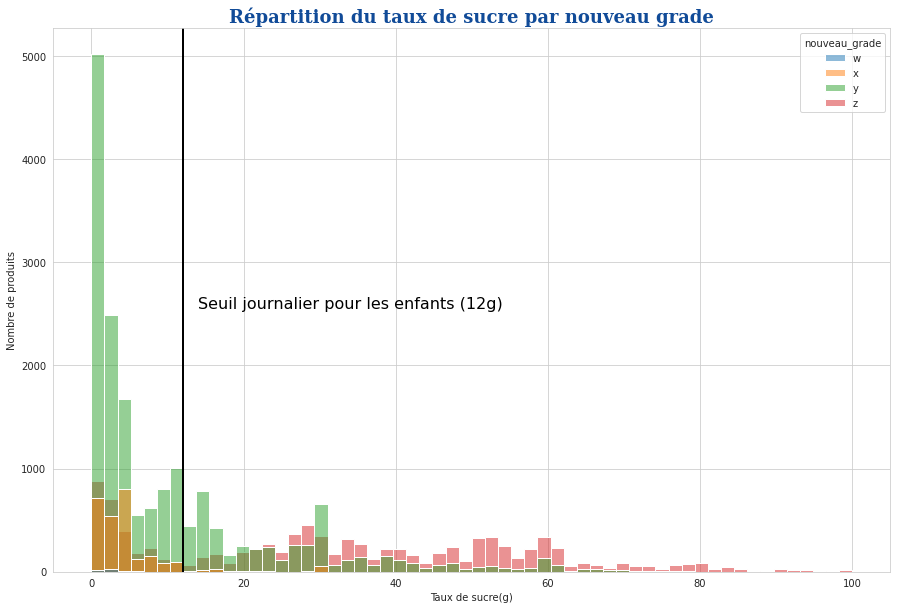

In [31]:
fig=plt.figure(figsize=(15,10))

font_title = {'family': 'serif',
              'color':  '#114b98',
              'weight': 'bold',
              'size': 18,
             }
seuil_sucre = 12
sns.set_style("whitegrid")
sns.histplot(data=df_extend.sort_values("nouveau_grade"), x='sugars_100g', hue="nouveau_grade", color='#00afe6')
plt.axvline(x=seuil_sucre, linewidth=2, color = 'black')
plt.text(seuil_sucre+2, 2550, 'Seuil journalier pour les enfants (12g)', fontsize = 16, color = 'black')

plt.title("Répartition du taux de sucre par nouveau grade", fontdict=font_title)
plt.xlabel("Taux de sucre(g)")
plt.ylabel("Nombre de produits")
plt.show()

In [34]:
nouveau_grade = df_extend.groupby(by='nouveau_grade')['code'].nunique().sort_values(ascending=False)
nouveau_grade

nouveau_grade
y    17492
z     9971
x     2674
w       62
Name: code, dtype: int64

In [43]:
ngrade_a = (df_extend.where(df_extend['nutrition_grade_fr']== 'a')).groupby(by='nouveau_grade')['code'].nunique().sort_values(ascending=False)
ngrade_a

nouveau_grade
y    4184
x    1391
z      95
w      61
Name: code, dtype: int64

In [44]:
ngrade_b = (df_extend.where(df_extend['nutrition_grade_fr']== 'b')).groupby(by='nouveau_grade')['code'].nunique().sort_values(ascending=False)
ngrade_b

nouveau_grade
y    3900
x     971
z     374
w       1
Name: code, dtype: int64

In [45]:
ngrade_c = (df_extend.where(df_extend['nutrition_grade_fr']== 'c')).groupby(by='nouveau_grade')['code'].nunique().sort_values(ascending=False)
ngrade_c

nouveau_grade
y    2349
z     919
x     148
Name: code, dtype: int64

In [46]:
ngrade_d = (df_extend.where(df_extend['nutrition_grade_fr']== 'd')).groupby(by='nouveau_grade')['code'].nunique().sort_values(ascending=False)
ngrade_d

nouveau_grade
y    6302
z    4722
x     160
Name: code, dtype: int64

In [47]:
ngrade_e = (df_extend.where(df_extend['nutrition_grade_fr']== 'e')).groupby(by='nouveau_grade')['code'].nunique().sort_values(ascending=False)
ngrade_e

nouveau_grade
z    3861
y     757
x       4
Name: code, dtype: int64

In [48]:
ancien_grade = df_extend.groupby(by='nutrition_grade_fr')['code'].nunique().sort_values(ascending=False)
ancien_grade

nutrition_grade_fr
d    11184
a     5731
b     5246
e     4622
c     3416
Name: code, dtype: int64

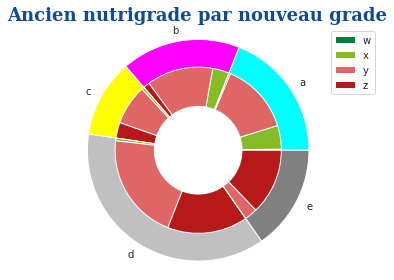

In [81]:
#ancien_grade = df_extend.groupby(by='nutrition_grade_fr')['code'].nunique().sort_values(ascending=False)
#nouveau_grade = df_extend.groupby(by='nouveau_grade')['code'].nunique().sort_values(ascending=False)
ancien_grade_nb = [5731,5246,3416,11184,4622]
ancien_grade_label = ['a','b','c','d','e']
ancien_grade_couleur = ['#00FFFF','#FF00FF','#FFFF00','#C0C0C0','#808080']
nouveau_grade_nb = [61,1391,4184,95,1,971,3900,374,0,148,2349,919,0,160,6302,4722,0,4,757,3861]
nouveau_grade_label = ['w','x','y','z','w','x','y','z','w','x','y','z','w','x','y','z','w','x','y','z']
nouveau_grade_couleur = ['#00803D','#86BC25','#E06666','#B71918','#00803D','#86BC25','#E06666','#B71918','#00803D','#86BC25','#E06666','#B71918','#00803D','#86BC25','#E06666','#B71918','#00803D','#86BC25','#E06666','#B71918']
plt.pie(ancien_grade_nb, colors=ancien_grade_couleur, labels=ancien_grade_label, startangle=0, frame=True)
patches, texts = plt.pie(nouveau_grade_nb, colors=nouveau_grade_couleur, radius=0.75,startangle=0)
centre_circle = plt.Circle((0,0),0.4,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
labels = ['w','x','y','z']
plt.legend(patches, labels, loc="best")
plt.title("Ancien nutrigrade par nouveau grade", fontdict=font_title)
plt.axis('equal')
plt.tight_layout()
plt.savefig("../images/camembert-old-new-grade.png")
plt.show()